Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [211]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_attacking_midfielder"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle','shooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']


PLAYER_ATTRIBUTES = [ 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',  'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'Composure', 'Reactions',  
                      'ShotPower', 'Jumping',  'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties'                     ]



In [212]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves
import config as CONFIG

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [213]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [214]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,age_based_Reactions,age_based_Dribbling,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,17.502664,31.843694,-3.713144,29.699822,2.902309,31.346359,27.808171,36.721137,27.376554,33.410894
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,13.717460,28.879365,9.719048,32.160635,11.850794,28.977778,15.171429,34.958730,26.241270,33.225397
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,12.830986,20.380282,8.190781,16.056082,9.382843,16.982074,15.554417,20.797695,15.592830,15.660265
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,14.938728,19.894798,2.326590,19.198382,9.764162,23.989595,23.932948,24.187283,20.012717,22.174181
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,14.938728,19.894798,0.326590,20.598382,16.764162,26.989595,12.932948,26.187283,14.012717,26.840848


# 

In [215]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [216]:
df = df[(df.central == 1)&(df.offense == 0.5)]

# Training nur auf High Potentials
df = df[df.max_potential>TARGET_OVERALL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
79.0    19
78.0    18
77.0    18
75.0    18
81.0    16
80.0    16
73.0    15
70.0    11
71.0    11
72.0    11
74.0     9
84.0     9
85.0     8
67.0     7
65.0     7
83.0     7
76.0     7
82.0     7
68.0     6
88.0     5
86.0     2
89.0     2
63.0     2
87.0     2
66.0     2
91.0     1
90.0     1
62.0     1
Name: count, dtype: int64


In [217]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
200949,Lucas,2012,18.0,18.0,26.0,90.0,90.0,82.0,83.0,83.0,train,CAM
245371,T. Almada,2021,19.0,19.0,22.0,89.0,89.0,73.0,79.0,79.0,test,CAM
233927,Lucas Paquetá,2020,21.0,21.0,24.0,89.0,89.0,79.0,82.0,82.0,test,CAM
220834,Marco Asensio,2017,20.0,20.0,22.0,89.0,89.0,81.0,85.0,85.0,train,CAM
191180,J. Pastore,2012,22.0,22.0,27.0,89.0,89.0,83.0,85.0,85.0,train,CAM


In [218]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [219]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Composure', 'Defensive awareness', 'mental'], dtype='object')

#### Transform Value

In [220]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

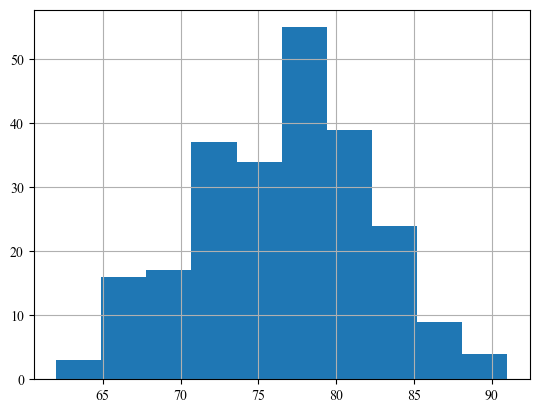

In [221]:
df['target'].hist()

In [222]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [223]:
df_processed.columns

Index(['potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Composure',
       'Defensive awareness', 'max_potential', 'prime_age', 'PrimeOverall',
       'best_position', 'central', 'winger', 'offense', 'Defense',
       'overall_age_ratio', 'youth_player', 'shooting', 'shooting_technique',
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Strength',
       'age_based_React

In [224]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [225]:
y_train.describe()

count    150.000000
mean      77.160000
std        5.685351
min       63.000000
25%       73.000000
50%       78.000000
75%       81.000000
max       91.000000
Name: target, dtype: float64

In [226]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [227]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [228]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [229]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


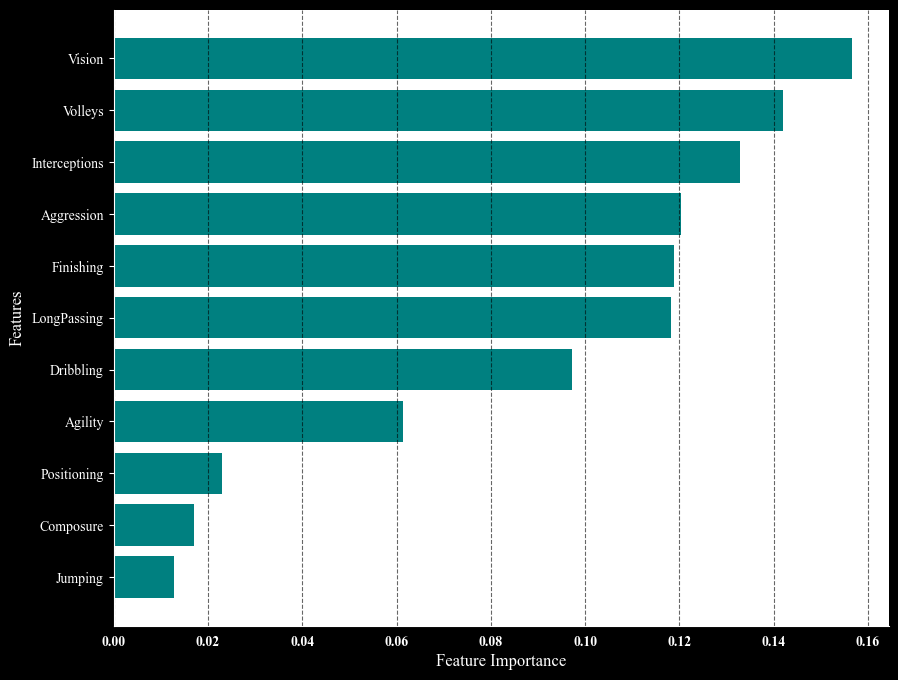

100%|██████████| 30/30 [00:12<00:00,  2.44it/s]


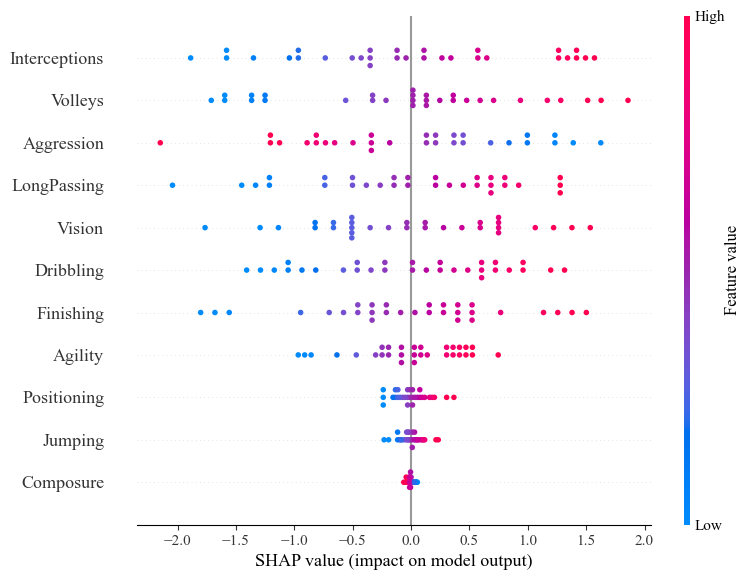

              precision    recall  f1-score   support

       False       0.95      0.78      0.86        27
        True       0.25      0.67      0.36         3

    accuracy                           0.77        30
   macro avg       0.60      0.72      0.61        30
weighted avg       0.88      0.77      0.81        30

Huber Regression training----->


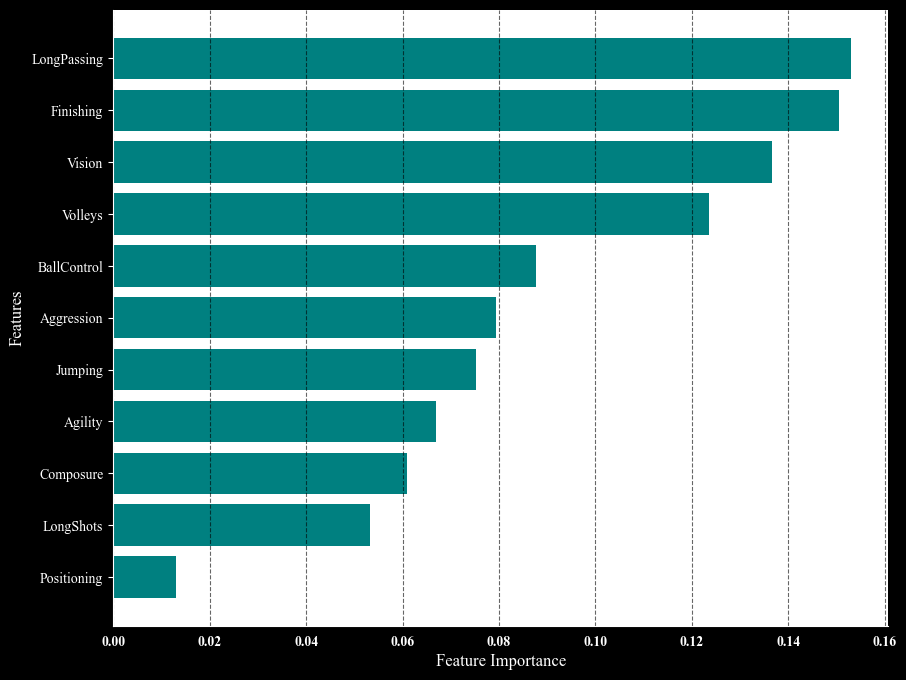

100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


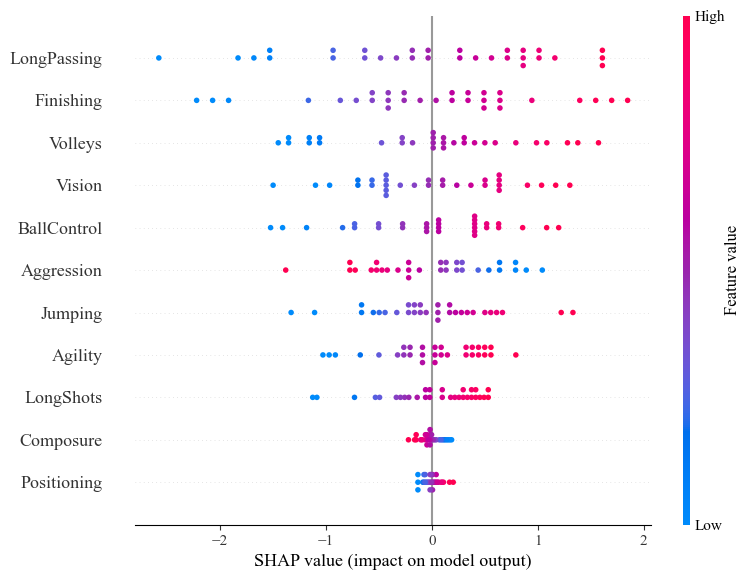

              precision    recall  f1-score   support

       False       0.96      0.96      0.96        27
        True       0.67      0.67      0.67         3

    accuracy                           0.93        30
   macro avg       0.81      0.81      0.81        30
weighted avg       0.93      0.93      0.93        30

Linear Regression training----->


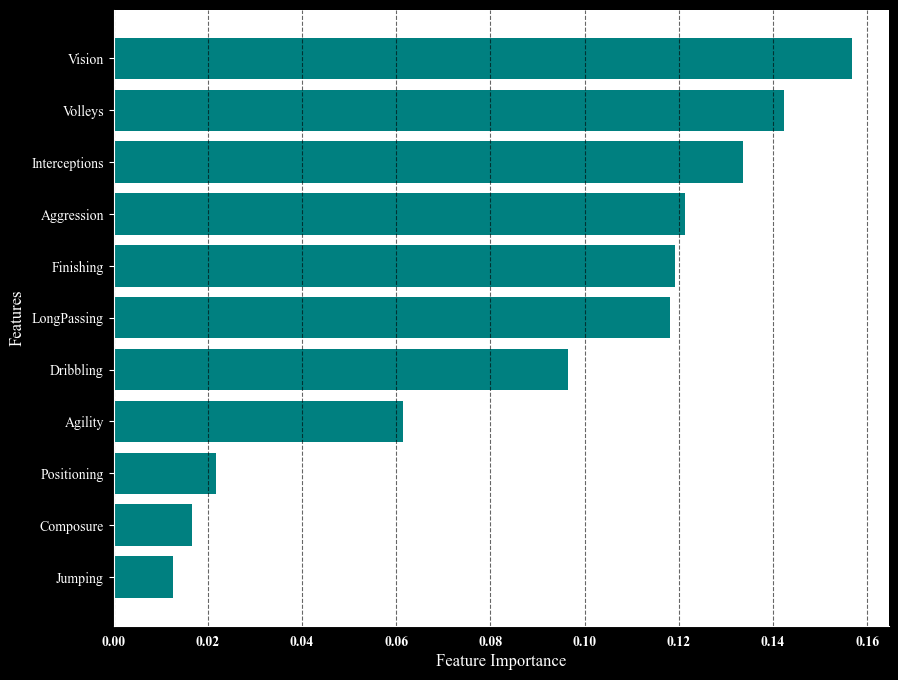

100%|██████████| 30/30 [00:18<00:00,  1.66it/s]


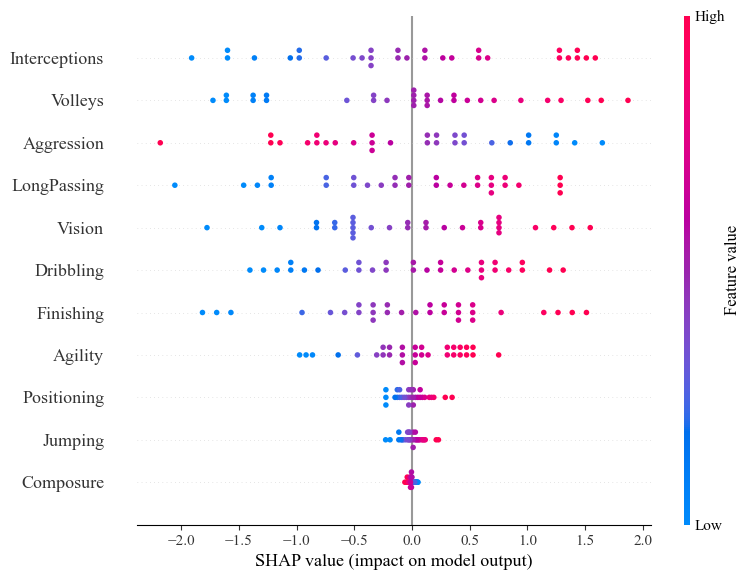

              precision    recall  f1-score   support

       False       0.95      0.78      0.86        27
        True       0.25      0.67      0.36         3

    accuracy                           0.77        30
   macro avg       0.60      0.72      0.61        30
weighted avg       0.88      0.77      0.81        30

Model: Ridge Regression
Mean Squared Error: 12.70
Mean Absolute Error: 2.95
R2 Score: 0.54

Model: Huber Regression
Mean Squared Error: 10.89
Mean Absolute Error: 2.66
R2 Score: 0.61

Model: Linear Regression
Mean Squared Error: 12.69
Mean Absolute Error: 2.95
R2 Score: 0.54



In [230]:
from sklearn.linear_model import LinearRegression,HuberRegressor

from src.sport_analytics.model.eval import plot_feature_importance, log_metrics_in_mlflow_regression,log_metrics_in_mlflow, log_feature_list_as_artifact, plot_shap_summary
from src.sport_analytics.model.prepare import select_features
from src.sport_analytics.utils import *
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    # 'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}
import datetime
# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():
    from datetime import datetime

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        from sklearn.metrics import  classification_report
        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [231]:
from src.sport_analytics.model.utils import *
if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.TRAINED_MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [232]:
X_train.describe()

,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,LongPassing,BallControl,Acceleration,SprintSpeed,...,Reactions,ShotPower,Jumping,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,...,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,61.520000,48.313333,71.520000,57.840000,73.860000,65.473333,65.533333,74.020000,76.060000,73.993333,...,64.933333,64.433333,59.346667,50.593333,62.940000,47.566667,36.486667,64.406667,69.553333,59.326667
std,7.425441,9.981282,6.125883,9.420868,6.276653,9.850355,7.612835,5.750366,7.387846,7.066792,...,8.640988,9.399712,10.098832,13.398436,10.023616,11.685715,13.203486,8.418657,7.613602,8.336462
min,42.000000,23.000000,59.000000,31.000000,58.000000,31.000000,47.000000,60.000000,56.000000,51.000000,...,43.000000,38.000000,29.000000,21.000000,34.000000,21.000000,13.000000,40.000000,43.000000,40.000000
25%,57.000000,42.000000,67.000000,52.000000,70.000000,60.000000,60.000000,70.000000,71.000000,70.000000,...,58.000000,58.000000,53.000000,40.000000,57.250000,39.250000,26.000000,60.000000,64.000000,53.000000
50%,62.000000,48.000000,72.000000,58.000000,74.500000,65.500000,66.000000,74.000000,76.500000,75.000000,...,65.000000,65.500000,59.000000,50.500000,64.000000,47.000000,34.000000,65.000000,69.500000,60.000000
75%,68.000000,54.750000,75.000000,64.000000,78.000000,72.000000,71.000000,77.000000,81.750000,78.000000,...,72.000000,71.000000,66.000000,60.750000,70.000000,55.000000,43.750000,70.000000,75.000000,65.000000
max,77.000000,75.000000,90.000000,78.000000,91.000000,86.000000,85.000000,90.000000,92.000000,90.000000,...,87.000000,86.000000,84.000000,79.000000,82.000000,80.000000,68.000000,85.000000,90.000000,84.000000


In [233]:
y_test.describe()

count    30.000000
mean     74.333333
std       5.345532
min      65.000000
25%      70.250000
50%      74.500000
75%      78.750000
max      84.000000
Name: target, dtype: float64

In [234]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [235]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

30

<Axes: >

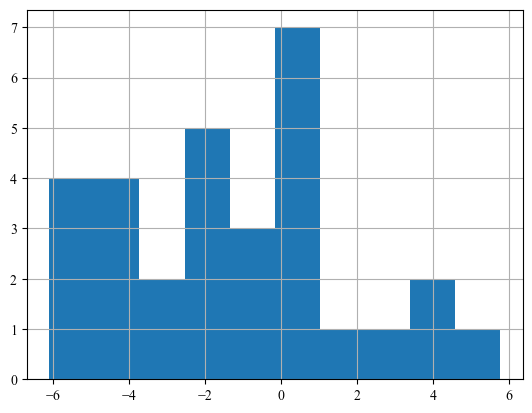

In [236]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

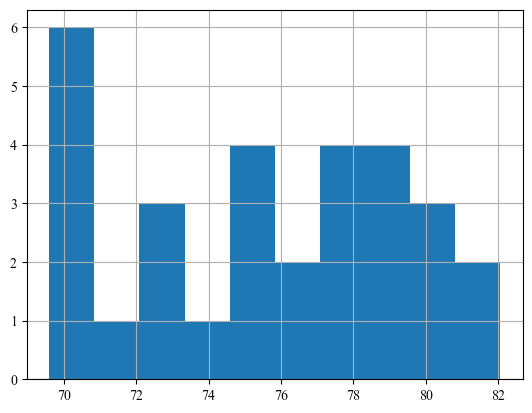

In [237]:
result_df.sort_values(ascending=False).hist()

In [238]:
(y_test-result_df).describe()

count    30.000000
mean     -1.243303
std       3.109041
min      -6.105595
25%      -3.950905
50%      -1.262721
75%       0.366678
max       5.766374
dtype: float64

In [239]:
outlier = (y_test-result_df)>3
X_test[outlier]


,,,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,LongPassing,BallControl,Acceleration,SprintSpeed,...,Reactions,ShotPower,Jumping,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
256630,F. Wirtz,2021,66.0,43.0,67.0,59.0,74.0,61.0,64.0,76.0,72.0,76.0,...,57.0,62.0,51.0,50.0,63.0,51.0,37.0,58.0,65.0,60.0
251570,R. Cherki,2021,61.0,28.0,67.0,51.0,75.0,66.0,53.0,73.0,71.0,71.0,...,63.0,64.0,35.0,61.0,57.0,57.0,21.0,62.0,64.0,61.0
246350,E. Le Fée,2021,48.0,44.0,74.0,45.0,71.0,68.0,71.0,73.0,63.0,66.0,...,58.0,56.0,62.0,34.0,48.0,50.0,57.0,64.0,72.0,54.0


In [240]:
y_test[outlier]

ID      Name       FIFA
256630  F. Wirtz   2021    82.0
251570  R. Cherki  2021    75.0
246350  E. Le Fée  2021    77.0
Name: target, dtype: float64

In [241]:
result_df[outlier]

ID      Name       FIFA
256630  F. Wirtz   2021    76.233626
251570  R. Cherki  2021    70.626147
246350  E. Le Fée  2021    72.861297
dtype: float64

In [242]:
(y_test/result_df).describe()

count    30.000000
mean      0.983150
std       0.042057
min       0.916483
25%       0.947486
50%       0.983578
75%       1.004709
max       1.075641
dtype: float64

In [243]:
(y_test/result_df).describe()

count    30.000000
mean      0.983150
std       0.042057
min       0.916483
25%       0.947486
50%       0.983578
75%       1.004709
max       1.075641
dtype: float64

In [244]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.82014654],
       [0.82014654, 1.        ]])

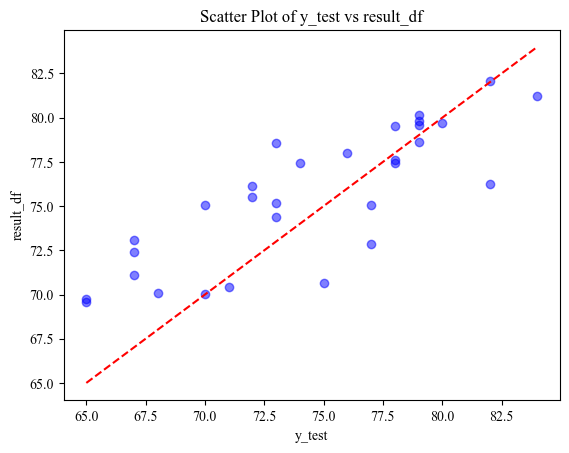

In [245]:
import matplotlib.pyplot as plt
plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [246]:
result_df = result_df.sort_values(ascending=False)

In [247]:
result_df.head(50)

ID      Name            FIFA
233927  Lucas Paquetá   2020    82.060691
237692  P. Foden        2021    81.215749
235008  L. Robertone    2020    80.147551
245371  T. Almada       2021    79.820515
241095  N. Vlašić       2020    79.670999
244261  L. Majer        2020    79.558593
233556  R. Orsolini     2020    79.530606
242187  C. Baumgartner  2021    78.649410
246419  Y. Verschaeren  2020    78.566458
234505  Evander         2021    78.002717
240699  N. De la Cruz   2020    77.627959
226568  I. Hagi         2021    77.450308
240787  H. Traorè       2020    77.433141
256630  F. Wirtz        2021    76.233626
252038  Romário Baró    2020    76.157150
256970  A. Karabec      2021    75.495277
227978  M. Mehlem       2020    75.164289
246960  M. Ihattaren    2020    75.081927
232669  S. Singh        2020    75.051027
243792  Iñigo Vicente   2020    74.377892
245340  L. Sibley       2021    73.105595
246350  E. Le Fée       2021    72.861297
243646  B. Nygren       2020    72.412906
24609

In [248]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

2


ID      Name           FIFA
233927  Lucas Paquetá  2020    82.060691
237692  P. Foden       2021    81.215749
dtype: float64

In [249]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

2


ID      Name       FIFA
241095  N. Vlašić  2020    79.670999
256630  F. Wirtz   2021    76.233626
dtype: float64

In [250]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

1


ID      Name          FIFA
235008  L. Robertone  2020    80.147551
dtype: float64

In [251]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

25


ID      Name            FIFA
251570  R. Cherki       2021    70.626147
246099  K. Goudmijn     2020    71.102781
243646  B. Nygren       2020    72.412906
246350  E. Le Fée       2021    72.861297
245340  L. Sibley       2021    73.105595
243792  Iñigo Vicente   2020    74.377892
232669  S. Singh        2020    75.051027
246960  M. Ihattaren    2020    75.081927
227978  M. Mehlem       2020    75.164289
256970  A. Karabec      2021    75.495277
252038  Romário Baró    2020    76.157150
240787  H. Traorè       2020    77.433141
226568  I. Hagi         2021    77.450308
240699  N. De la Cruz   2020    77.627959
234505  Evander         2021    78.002717
246419  Y. Verschaeren  2020    78.566458
242187  C. Baumgartner  2021    78.649410
233556  R. Orsolini     2020    79.530606
244261  L. Majer        2020    79.558593
245371  T. Almada       2021    79.820515
dtype: float64

In [252]:
from sklearn.metrics import  classification_report
print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.82      0.56      0.67        16
        True       0.63      0.86      0.73        14

    accuracy                           0.70        30
   macro avg       0.72      0.71      0.70        30
weighted avg       0.73      0.70      0.69        30

